# Forecasting Net Pipeline Value
#### Aim : Apply different algorithms and choose the best one to predict the Net Pipeline Value on 1st October 2020

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.ar_model import AR,ARResults

from sklearn.metrics import r2_score
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

/home/shivangmathur/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/shivangmathur/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


#### Data Analysis and Data Processing

In [2]:
df = pd.read_excel('For Shivang Mathur.xlsx',parse_dates=True)

In [3]:
df = df[['pull_date','npv( Net Pipeline Value )']]

In [4]:
df

,pull_date,npv( Net Pipeline Value )
0,2020-07-03,24895276.32
1,2020-07-02,23111985.60
2,2020-07-01,23192385.60
3,2020-06-30,23350128.00
4,2020-06-29,23210928.00
...,...,...
597,2018-11-12,9340627.20
598,2018-10-28,8504467.20
599,2018-10-21,7462627.20
600,2018-10-14,6898027.20


In [5]:
df.sort_values(by=['pull_date'],inplace=True)

In [6]:
df.index = df['pull_date']
df = df[['npv( Net Pipeline Value )']]

In [7]:
all_days = pd.date_range(df.index.min(), df.index.max(), freq='D')
df=(df.reindex(all_days))
df=df.fillna(df.mean())

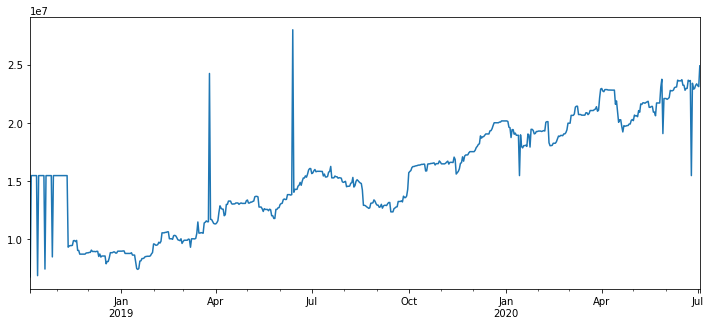

In [8]:
df['npv( Net Pipeline Value )'].plot(figsize=(12,5)).autoscale(axis='x',tight=True);

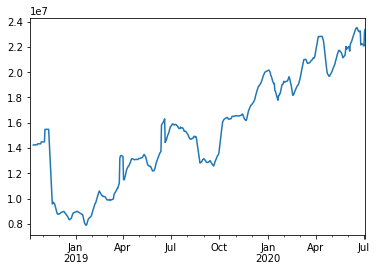

In [9]:
df.rolling(window=7).mean()['npv( Net Pipeline Value )'].plot();

In [10]:
#train-test split
train = df.iloc[:-60]
test = df.iloc[-60:]

We will check the performance of each algorithm on a validation set of 60 days.

### 1. Auto Regressive Model

In [11]:
model = AR(train['npv( Net Pipeline Value )'])
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const                           1.028558e+06
L1.npv( Net Pipeline Value )    9.305805e-01
dtype: float64


In [12]:
start=len(train)
end=len(train)+len(test)-1

In [13]:
rmse = []
model_name = []
predictions = AR1fit.predict(start=start, end=end, dynamic=False)
rmse.append(sqrt(mean_squared_error(test['npv( Net Pipeline Value )'], predictions)))
model_name.append('AR')

### 2. ARMA

In [14]:
model = ARMA(train['npv( Net Pipeline Value )'],order=(1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                 
=====================================================================================
Dep. Variable:     npv( Net Pipeline Value )   No. Observations:                  576
Model:                            ARMA(1, 1)   Log Likelihood               -8899.546
Method:                              css-mle   S.D. of innovations        1238031.130
Date:                       Wed, 26 Aug 2020   AIC                          17807.091
Time:                               01:29:27   BIC                          17824.516
Sample:                           10-07-2018   HQIC                         17813.887
                                - 05-04-2020                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.477e+07   2.72e+06      5.427      0.000    9.44e+06    2.01e+07
ar.L1.npv( Net Pipeline Value )     0.9954      0.004    271.498      0.000       0.988       1.003
ma.L1.npv( Net Pipeline Value )    -0.6864      0.031    -22.166      0.000      -0.747      -0.626
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0046           +0.0000j            1.0046            0.0000
MA.1            1.4569           +0.0000j            1.4569            0.0000
-----------------------------------------------------------------------------
"""

In [15]:
predictions = results.predict(start=start, end=end)
rmse.append(sqrt(mean_squared_error(test['npv( Net Pipeline Value )'], predictions)))
model_name.append('AR')

#### 3. SARIMAX

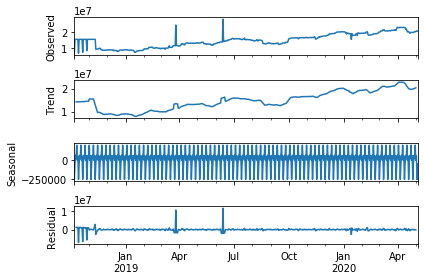

In [16]:
result = seasonal_decompose(train['npv( Net Pipeline Value )'])
result.plot();

In [17]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(train['npv( Net Pipeline Value )'],seasonal=True,m=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  576
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 4)   Log Likelihood               -8918.543
Date:                           Wed, 26 Aug 2020   AIC                          17849.086
Time:                                   01:29:34   BIC                          17875.212
Sample:                                        0   HQIC                         17859.276
                                           - 576                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.192e+04   3.43e+04      0.638      0.523   -4.54e+04    8.92e+04
ar.L1          0.1111      0.026      4.293      0.000       0.060       0.162
ma.L1         -0.6846      0.025    -26.851      0.000      -0.735      -0.635
ar.S.L4       -0.8875      0.118     -7.549      0.000      -1.118      -0.657
ma.S.L4        0.8352      0.138      6.056      0.000       0.565       1.106
sigma2      1.464e+12      0.061   2.41e+13      0.000    1.46e+12    1.46e+12
===================================================================================
Ljung-Box (Q):                       69.51   Jarque-Bera (JB):             67013.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             3.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.36e+27. Standard errors may be unstable.
"""

In [18]:
model = SARIMAX(train['npv( Net Pipeline Value )'],order=(1,1,1),seasonal_order=(1,0,1,4),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:         npv( Net Pipeline Value )   No. Observations:                  576
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 4)   Log Likelihood               -8919.108
Date:                           Wed, 26 Aug 2020   AIC                          17848.215
Time:                                   01:29:35   BIC                          17869.987
Sample:                               10-07-2018   HQIC                         17856.707
                                    - 05-04-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1073      0.026      4.131      0.000       0.056       0.158
ma.L1         -0.6795      0.025    -26.901      0.000      -0.729      -0.630
ar.S.L4       -0.8891      0.114     -7.809      0.000      -1.112      -0.666
ma.S.L4        0.8367      0.135      6.215      0.000       0.573       1.100
sigma2      1.464e+12   4.07e-13   3.59e+24      0.000    1.46e+12    1.46e+12
===================================================================================
Ljung-Box (Q):                       68.92   Jarque-Bera (JB):             67174.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             3.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.46e+39. Standard errors may be unstable.
"""

In [19]:
# Obtain predicted values

predictions = results.predict(start=start, end=end, dynamic=False)

In [20]:
rmse.append(sqrt(mean_squared_error(test['npv( Net Pipeline Value )'], predictions)))
model_name.append('AR')

#### 4. LSTM

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [22]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [23]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [24]:
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [26]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [28]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [30]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
558/558 [==============================] - 4s 8ms/step - loss: 0.0095 - val_loss: 0.0051
Epoch 2/20
558/558 [==============================] - 9s 17ms/step - loss: 0.0038 - val_loss: 0.0070
Epoch 3/20
558/558 [==============================] - 9s 16ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 4/20
558/558 [==============================] - 10s 17ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 5/20
558/558 [==============================] - 9s 17ms/step - loss: 0.0031 - val_loss: 0.0054


In [31]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [32]:
predictions = scaler.inverse_transform(test_predictions)

In [33]:
rmse.append(sqrt(mean_squared_error(test['npv( Net Pipeline Value )'], predictions)))
model_name.append('LSTM')

#### 5. Fb Prophet

In [34]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

Importing plotly failed. Interactive plots will not work.


In [35]:
dff = pd.DataFrame({'ds': df.index,'y':df['npv( Net Pipeline Value )']})
dff.reset_index(drop=True, inplace=True)

In [36]:
prediction_size = 60
train_df = dff[:-prediction_size]

In [37]:
m = Prophet(yearly_seasonality=True,daily_seasonality=True)
m.fit(train_df)

In [38]:
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

In [39]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))


In [40]:
cmp_df = make_comparison_dataframe(dff.tail(60), forecast.tail(60))


In [41]:
cmp_df

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-05-05,2.100916e+07,1.943612e+07,2.267639e+07,2.053332e+07
2020-05-06,2.093780e+07,1.929956e+07,2.252188e+07,2.105652e+07
2020-05-07,2.110570e+07,1.957426e+07,2.272003e+07,2.091732e+07
2020-05-08,2.088501e+07,1.934501e+07,2.244171e+07,2.162832e+07
2020-05-09,2.091554e+07,1.942775e+07,2.255310e+07,2.158032e+07
2020-05-10,2.049597e+07,1.895659e+07,2.199978e+07,2.172312e+07
2020-05-11,2.075778e+07,1.922780e+07,2.232307e+07,2.172312e+07
2020-05-12,2.082696e+07,1.925888e+07,2.243802e+07,2.168472e+07
2020-05-13,2.072521e+07,1.919213e+07,2.227214e+07,2.175432e+07


In [42]:
rmse.append(sqrt(mean_squared_error(test['npv( Net Pipeline Value )'], forecast.iloc[-60:]['yhat'])))
model_name.append('Fb Prophet')

#### 6. XgBoost with Fastai

In [43]:
train = dff.iloc[:-60]
test_xgb = dff.iloc[-60:]

In [44]:
y_train = pd.Series(list(train['y']))
y_test = (test_xgb['y'])

In [45]:
def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

In [46]:
import re
add_datepart(train, 'ds')
add_datepart(test_xgb, 'ds')

In [47]:
X_train =train.drop('y',axis=1)
X_test =test_xgb.drop('y',axis=1)

In [48]:
import xgboost as xgb
params = {
    'booster': 'gbtree', 
    'objective': 'reg:squarederror', # regression task
    'subsample': 0.7, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.7, # 89% of features used
    'eta': 0.01, 
    'max_depth': 5, 
    'gamma':2,
    'seed': 42} # for reproducible results


dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)


watchlist = [(dtrain, 'train'),(dtest,'test')]

xgb_model = xgb.train(params, dtrain, 12000,early_stopping_rounds = 200, evals = watchlist, verbose_eval = True)


[0]	train-rmse:1.51746e+07	test-rmse:2.21201e+07
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
[1]	train-rmse:1.50256e+07	test-rmse:2.19244e+07
[2]	train-rmse:1.48794e+07	test-rmse:2.173e+07
[3]	train-rmse:1.47335e+07	test-rmse:2.15384e+07
[4]	train-rmse:1.45896e+07	test-rmse:2.13474e+07
[5]	train-rmse:1.44474e+07	test-rmse:2.11581e+07
[6]	train-rmse:1.43135e+07	test-rmse:2.10194e+07
[7]	train-rmse:1.41737e+07	test-rmse:2.08348e+07
[8]	train-rmse:1.40347e+07	test-rmse:2.06516e+07
[9]	train-rmse:1.38977e+07	test-rmse:2.04693e+07
[10]	train-rmse:1.37615e+07	test-rmse:2.02894e+07
[11]	train-rmse:1.36267e+07	test-rmse:2.01113e+07
[12]	train-rmse:1.34934e+07	test-rmse:1.99361e+07
[13]	train-rmse:1.3362e+07	test-rmse:1.97633e+07
[14]	train-rmse:1.32313e+07	test-rmse:1.95915e+07
[15]	train-rmse:1.31024e+07	test-rmse:1.94215e+07
[16]	train-rmse:1.29743e+07	test-rmse:1.92523e+07
[17]	train-rmse:1.2

[161]	train-rmse:3.28094e+06	test-rmse:6.06468e+06
[162]	train-rmse:3.25182e+06	test-rmse:6.03185e+06
[163]	train-rmse:3.22261e+06	test-rmse:5.9882e+06
[164]	train-rmse:3.19411e+06	test-rmse:5.9461e+06
[165]	train-rmse:3.16553e+06	test-rmse:5.90253e+06
[166]	train-rmse:3.13724e+06	test-rmse:5.87174e+06
[167]	train-rmse:3.10994e+06	test-rmse:5.8297e+06
[168]	train-rmse:3.0823e+06	test-rmse:5.78705e+06
[169]	train-rmse:3.05439e+06	test-rmse:5.75698e+06
[170]	train-rmse:3.02732e+06	test-rmse:5.72585e+06
[171]	train-rmse:2.99979e+06	test-rmse:5.69667e+06
[172]	train-rmse:2.97274e+06	test-rmse:5.66788e+06
[173]	train-rmse:2.94683e+06	test-rmse:5.63444e+06
[174]	train-rmse:2.92281e+06	test-rmse:5.60813e+06
[175]	train-rmse:2.89751e+06	test-rmse:5.57298e+06
[176]	train-rmse:2.87242e+06	test-rmse:5.54517e+06
[177]	train-rmse:2.84768e+06	test-rmse:5.51734e+06
[178]	train-rmse:2.8243e+06	test-rmse:5.49122e+06
[179]	train-rmse:2.79988e+06	test-rmse:5.46333e+06
[180]	train-rmse:2.77479e+06	test-rm

[324]	train-rmse:955683	test-rmse:3.22862e+06
[325]	train-rmse:950718	test-rmse:3.22418e+06
[326]	train-rmse:945986	test-rmse:3.21773e+06
[327]	train-rmse:940631	test-rmse:3.21178e+06
[328]	train-rmse:935094	test-rmse:3.2063e+06
[329]	train-rmse:930583	test-rmse:3.19988e+06
[330]	train-rmse:926262	test-rmse:3.1906e+06
[331]	train-rmse:921721	test-rmse:3.18506e+06
[332]	train-rmse:916461	test-rmse:3.17731e+06
[333]	train-rmse:912191	test-rmse:3.17134e+06
[334]	train-rmse:906969	test-rmse:3.1637e+06
[335]	train-rmse:901989	test-rmse:3.15907e+06
[336]	train-rmse:897240	test-rmse:3.15351e+06
[337]	train-rmse:892462	test-rmse:3.14538e+06
[338]	train-rmse:888416	test-rmse:3.13917e+06
[339]	train-rmse:883271	test-rmse:3.13212e+06
[340]	train-rmse:879324	test-rmse:3.12729e+06
[341]	train-rmse:873845	test-rmse:3.12158e+06
[342]	train-rmse:869274	test-rmse:3.11589e+06
[343]	train-rmse:865169	test-rmse:3.11024e+06
[344]	train-rmse:860782	test-rmse:3.10535e+06
[345]	train-rmse:856794	test-rmse:3.0

[503]	train-rmse:480628	test-rmse:2.6259e+06
[504]	train-rmse:479450	test-rmse:2.62361e+06
[505]	train-rmse:478476	test-rmse:2.62209e+06
[506]	train-rmse:477548	test-rmse:2.62079e+06
[507]	train-rmse:476157	test-rmse:2.61935e+06
[508]	train-rmse:474964	test-rmse:2.61855e+06
[509]	train-rmse:473895	test-rmse:2.61695e+06
[510]	train-rmse:472720	test-rmse:2.61558e+06
[511]	train-rmse:471015	test-rmse:2.61432e+06
[512]	train-rmse:470468	test-rmse:2.6141e+06
[513]	train-rmse:469313	test-rmse:2.61324e+06
[514]	train-rmse:467825	test-rmse:2.61169e+06
[515]	train-rmse:466366	test-rmse:2.61048e+06
[516]	train-rmse:465214	test-rmse:2.60936e+06
[517]	train-rmse:463964	test-rmse:2.60836e+06
[518]	train-rmse:462851	test-rmse:2.60804e+06
[519]	train-rmse:461651	test-rmse:2.6063e+06
[520]	train-rmse:460211	test-rmse:2.60482e+06
[521]	train-rmse:459125	test-rmse:2.6039e+06
[522]	train-rmse:458629	test-rmse:2.60261e+06
[523]	train-rmse:457801	test-rmse:2.60083e+06
[524]	train-rmse:457248	test-rmse:2.60

[682]	train-rmse:337961	test-rmse:2.4962e+06
[683]	train-rmse:337414	test-rmse:2.49605e+06
[684]	train-rmse:337289	test-rmse:2.49604e+06
[685]	train-rmse:336750	test-rmse:2.49571e+06
[686]	train-rmse:335834	test-rmse:2.49496e+06
[687]	train-rmse:335608	test-rmse:2.49521e+06
[688]	train-rmse:335031	test-rmse:2.4952e+06
[689]	train-rmse:334301	test-rmse:2.4943e+06
[690]	train-rmse:333375	test-rmse:2.49321e+06
[691]	train-rmse:332465	test-rmse:2.4928e+06
[692]	train-rmse:332020	test-rmse:2.49276e+06
[693]	train-rmse:331494	test-rmse:2.49315e+06
[694]	train-rmse:330992	test-rmse:2.49267e+06
[695]	train-rmse:330530	test-rmse:2.4923e+06
[696]	train-rmse:329887	test-rmse:2.49167e+06
[697]	train-rmse:329375	test-rmse:2.49167e+06
[698]	train-rmse:329162	test-rmse:2.49188e+06
[699]	train-rmse:328467	test-rmse:2.49132e+06
[700]	train-rmse:327716	test-rmse:2.49096e+06
[701]	train-rmse:326862	test-rmse:2.49021e+06
[702]	train-rmse:326682	test-rmse:2.49043e+06
[703]	train-rmse:326517	test-rmse:2.489

[861]	train-rmse:263323	test-rmse:2.45921e+06
[862]	train-rmse:262808	test-rmse:2.45896e+06
[863]	train-rmse:262511	test-rmse:2.45884e+06
[864]	train-rmse:261906	test-rmse:2.45847e+06
[865]	train-rmse:261638	test-rmse:2.45846e+06
[866]	train-rmse:261443	test-rmse:2.45844e+06
[867]	train-rmse:261137	test-rmse:2.45819e+06
[868]	train-rmse:260800	test-rmse:2.45815e+06
[869]	train-rmse:260619	test-rmse:2.4578e+06
[870]	train-rmse:260124	test-rmse:2.45776e+06
[871]	train-rmse:259970	test-rmse:2.45751e+06
[872]	train-rmse:259484	test-rmse:2.4576e+06
[873]	train-rmse:259063	test-rmse:2.45737e+06
[874]	train-rmse:258731	test-rmse:2.45781e+06
[875]	train-rmse:258379	test-rmse:2.45778e+06
[876]	train-rmse:258204	test-rmse:2.4575e+06
[877]	train-rmse:257819	test-rmse:2.4574e+06
[878]	train-rmse:257568	test-rmse:2.45724e+06
[879]	train-rmse:257443	test-rmse:2.45694e+06
[880]	train-rmse:257075	test-rmse:2.45697e+06
[881]	train-rmse:256738	test-rmse:2.45658e+06
[882]	train-rmse:256374	test-rmse:2.45

[1039]	train-rmse:216614	test-rmse:2.45393e+06
[1040]	train-rmse:216305	test-rmse:2.45394e+06
[1041]	train-rmse:216105	test-rmse:2.45393e+06
[1042]	train-rmse:215972	test-rmse:2.45369e+06
[1043]	train-rmse:215798	test-rmse:2.45372e+06
[1044]	train-rmse:215453	test-rmse:2.45372e+06
[1045]	train-rmse:215287	test-rmse:2.45343e+06
[1046]	train-rmse:214936	test-rmse:2.45309e+06
[1047]	train-rmse:214647	test-rmse:2.4532e+06
[1048]	train-rmse:214435	test-rmse:2.45105e+06
[1049]	train-rmse:214198	test-rmse:2.45111e+06
[1050]	train-rmse:213924	test-rmse:2.45118e+06
[1051]	train-rmse:213545	test-rmse:2.45114e+06
[1052]	train-rmse:213424	test-rmse:2.45078e+06
[1053]	train-rmse:213112	test-rmse:2.45116e+06
[1054]	train-rmse:212595	test-rmse:2.45111e+06
[1055]	train-rmse:212199	test-rmse:2.45103e+06
[1056]	train-rmse:211931	test-rmse:2.45102e+06
[1057]	train-rmse:211773	test-rmse:2.45133e+06
[1058]	train-rmse:211406	test-rmse:2.45128e+06
[1059]	train-rmse:211140	test-rmse:2.45173e+06
[1060]	train-r

[1214]	train-rmse:183604	test-rmse:2.45622e+06
[1215]	train-rmse:183338	test-rmse:2.45621e+06
[1216]	train-rmse:183063	test-rmse:2.45623e+06
[1217]	train-rmse:182873	test-rmse:2.45602e+06
[1218]	train-rmse:182643	test-rmse:2.45597e+06
[1219]	train-rmse:182574	test-rmse:2.45597e+06
[1220]	train-rmse:182509	test-rmse:2.45633e+06
[1221]	train-rmse:182411	test-rmse:2.45603e+06
[1222]	train-rmse:182035	test-rmse:2.456e+06
[1223]	train-rmse:181985	test-rmse:2.45595e+06
[1224]	train-rmse:181914	test-rmse:2.45591e+06
[1225]	train-rmse:181677	test-rmse:2.45578e+06
[1226]	train-rmse:181615	test-rmse:2.45584e+06
[1227]	train-rmse:181409	test-rmse:2.45621e+06
[1228]	train-rmse:181091	test-rmse:2.45615e+06
[1229]	train-rmse:180847	test-rmse:2.45609e+06
[1230]	train-rmse:180816	test-rmse:2.45614e+06
[1231]	train-rmse:180743	test-rmse:2.45612e+06
[1232]	train-rmse:180698	test-rmse:2.45615e+06
[1233]	train-rmse:180492	test-rmse:2.45623e+06
[1234]	train-rmse:180299	test-rmse:2.45615e+06
[1235]	train-rm

In [49]:
pred= xgb_model.predict(dtest)

In [50]:
rmse.append(sqrt(mean_squared_error(test['npv( Net Pipeline Value )'], pred)))
model_name.append('AR')

### Comparison and Results

In [51]:
comparison = pd.DataFrame({'Model Name':model_name,'Root Mean Square Error':rmse})
comparison

,Model Name,Root Mean Square Error
0,AR,6.616189e+06
1,AR,3.049735e+06
2,AR,2.270993e+06
3,LSTM,4.017505e+06
4,Fb Prophet,1.500789e+06
5,AR,2.456519e+06


In [52]:
comparison[comparison['Root Mean Square Error']==comparison['Root Mean Square Error'].min()]['Model Name']

4    Fb Prophet
Name: Model Name, dtype: object

On comparing the results of all the algorithms we can see that Fb Prophet has given the lowest RMSE on the validation set. Now, we will train the same algorithm on the whole data and calculate predictions for our desired date.

In [53]:
from datetime import date, timedelta
sdate = date(2020,7,3)   # start date
edate = date(2020,10,2)   # end date

ds = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

In [54]:
df_predictions = pd.DataFrame({'ds' : ds})

In [55]:
m = Prophet(yearly_seasonality=True,daily_seasonality=True)
m.fit(dff)

In [56]:
forecast = m.predict(df_predictions)

In [57]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-03,1.532900e+07,2.148016e+07,2.475992e+07,1.532900e+07,1.532900e+07,7.769867e+06,7.769867e+06,7.769867e+06,6.051961e+06,...,926.145816,926.145816,926.145816,1.716980e+06,1.716980e+06,1.716980e+06,0.0,0.0,0.0,2.309886e+07
1,2020-07-04,1.534193e+07,2.148352e+07,2.473167e+07,1.534193e+07,1.534193e+07,7.802026e+06,7.802026e+06,7.802026e+06,6.051961e+06,...,63181.690697,63181.690697,63181.690697,1.686883e+06,1.686883e+06,1.686883e+06,0.0,0.0,0.0,2.314396e+07
2,2020-07-05,1.535486e+07,2.119382e+07,2.443381e+07,1.535486e+07,1.535486e+07,7.422186e+06,7.422186e+06,7.422186e+06,6.051961e+06,...,-288894.277909,-288894.277909,-288894.277909,1.659119e+06,1.659119e+06,1.659119e+06,0.0,0.0,0.0,2.277705e+07
3,2020-07-06,1.536779e+07,2.133544e+07,2.463978e+07,1.536779e+07,1.536779e+07,7.675636e+06,7.675636e+06,7.675636e+06,6.051961e+06,...,-10123.730650,-10123.730650,-10123.730650,1.633799e+06,1.633799e+06,1.633799e+06,0.0,0.0,0.0,2.304343e+07
4,2020-07-07,1.538072e+07,2.151939e+07,2.470116e+07,1.538072e+07,1.538072e+07,7.745601e+06,7.745601e+06,7.745601e+06,6.051961e+06,...,82748.121126,82748.121126,82748.121126,1.610892e+06,1.610892e+06,1.610892e+06,0.0,0.0,0.0,2.312633e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2020-09-27,1.644114e+07,1.837262e+07,2.184227e+07,1.581900e+07,1.708531e+07,3.735724e+06,3.735724e+06,3.735724e+06,6.051961e+06,...,-288894.277909,-288894.277909,-288894.277909,-2.027342e+06,-2.027342e+06,-2.027342e+06,0.0,0.0,0.0,2.017686e+07
87,2020-09-28,1.645407e+07,1.884049e+07,2.234316e+07,1.581445e+07,1.710543e+07,4.149454e+06,4.149454e+06,4.149454e+06,6.051961e+06,...,-10123.730650,-10123.730650,-10123.730650,-1.892384e+06,-1.892384e+06,-1.892384e+06,0.0,0.0,0.0,2.060352e+07
88,2020-09-29,1.646700e+07,1.911215e+07,2.271070e+07,1.581743e+07,1.712862e+07,4.378191e+06,4.378191e+06,4.378191e+06,6.051961e+06,...,82748.121125,82748.121125,82748.121125,-1.756518e+06,-1.756518e+06,-1.756518e+06,0.0,0.0,0.0,2.084519e+07
89,2020-09-30,1.647993e+07,1.919029e+07,2.273869e+07,1.581544e+07,1.715414e+07,4.467434e+06,4.467434e+06,4.467434e+06,6.051961e+06,...,36135.224243,36135.224243,36135.224243,-1.620662e+06,-1.620662e+06,-1.620662e+06,0.0,0.0,0.0,2.094737e+07


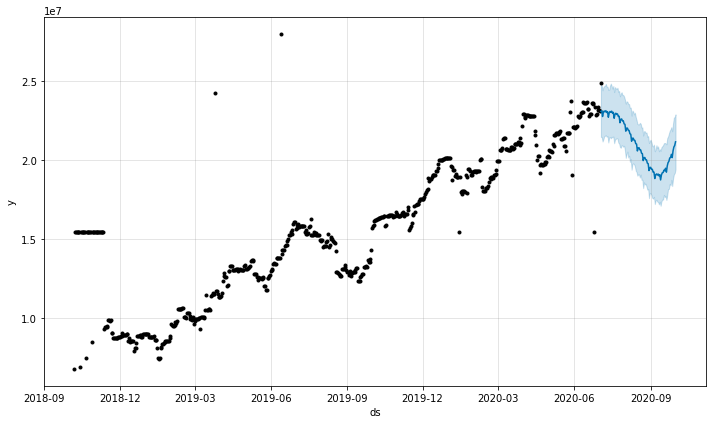

In [58]:
m.plot(forecast);

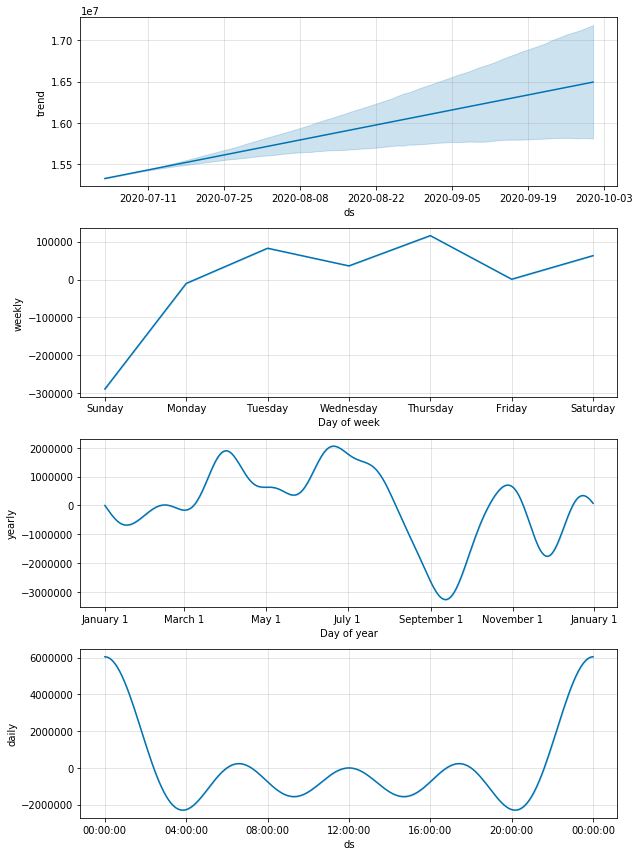

In [59]:
m.plot_components(forecast);

In [60]:
print("The value of Predicted PPV on 1st October 2020 is:",forecast.iloc[-1]['yhat'])

The value of Predicted PPV on 1st October 2020 is: 21175200.214999557
